# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

Our task, or the main objective here is to help a used car dealership identify what factors contribute to the pricing when selling a used car. Using those factors we will make a regression model to better predict the appropriate value for a car.


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

Some steps that I would like to take to get to know the dataset would to just first look at it as a whole. We are using a massive data set with information on 426,000 cars from an original set of 3 million used cars. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from scipy import stats

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer, LabelEncoder, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.inspection import permutation_importance


In [2]:
vehicles = pd.read_csv('vehicles.csv')
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

As we can see, from the .info() there is a large amount of info that is missing from the following columns: size, paint color, VIN, drive, and some others. Some of these data points I don't believe are very impactful when it comes to the valuation of a car, so we can work on removing that data. Let's take a sample to get a better understanding of what these catagories mean.

In [3]:
vehicles.sample(10)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
31562,7314900196,inland empire,94995,2019.0,ford,f-250sd,NaN,NaN,diesel,15566.0,clean,automatic,1FT7W2BT7KED12158,4wd,NaN,NaN,black,ca
36113,7313000835,merced,37088,2017.0,chevrolet,camaro 1ss,good,8 cylinders,gas,35239.0,clean,automatic,1G1FF1R70H0198503,rwd,NaN,coupe,red,ca
400519,7313859694,bellingham,21999,2017.0,subaru,impreza,NaN,4 cylinders,gas,70779.0,clean,manual,4S3GTAN6XH3703785,4wd,NaN,hatchback,custom,wa
204757,7308791124,kalamazoo,33990,2017.0,ram,1500 crew cab tradesman,good,8 cylinders,gas,17033.0,clean,other,3C6RR7KT7HG794054,4wd,NaN,pickup,blue,mi
104445,7316387486,orlando,5998,2014.0,ford,fiesta se,like new,4 cylinders,gas,89687.0,clean,automatic,3FADP4BJXEM202297,fwd,full-size,sedan,blue,fl
323365,7316563995,portland,6999,2009.0,ford,flex limited sport utility,excellent,6 cylinders,gas,175726.0,clean,automatic,NaN,fwd,full-size,hatchback,silver,or
231852,7316368526,charlotte,34590,2016.0,chevrolet,silverado 1500 double,good,6 cylinders,gas,29499.0,clean,other,1GCVKREH6GZ228691,4wd,NaN,pickup,silver,nc
256375,7315836720,south jersey,30990,2014.0,chevrolet,suburban 1500 ltz,good,8 cylinders,other,87922.0,clean,other,1GNSKKE74ER102173,4wd,NaN,other,white,nj
346170,7304697820,columbia,36590,2017.0,chevrolet,camaro ss coupe 2d,good,8 cylinders,gas,14020.0,clean,other,1G1FE1R76H0165878,rwd,NaN,coupe,blue,sc
215187,7316082087,minneapolis / st paul,1500,2002.0,chevrolet,tracker lt,fair,6 cylinders,gas,200000.0,clean,automatic,NaN,4wd,NaN,SUV,NaN,mn


In [4]:
vehicles.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


In [5]:
vehicles.isna().sum()

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

As I said before, we will work on nitpicking through the data so that we can better manipulate it. For example, I believe that since the VIN is a unique identifier and not really signifigant to the pricing of a car, so we will ignore it. We will also do this with the ID catagory for the same reason of being a unique identifier. I will also not use size and paint color due to the fact that it has so little information, and it may disrupt our calculations. 

I see there is a price catagory already, I assume this is refering to the initial purchase price, so let's plot that and take a look

In [6]:
vehicles["price"].value_counts()

0        32895
6995      3169
7995      3129
9995      2867
8995      2837
         ...  
21298        1
49217        1
63195        1
19709        1
17873        1
Name: price, Length: 15655, dtype: int64

Text(0, 0.5, 'Price')

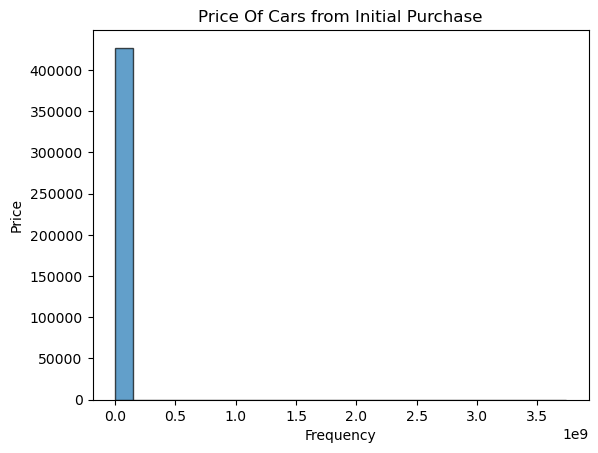

In [7]:
plt.hist(vehicles.price, bins=25, alpha = 0.7, edgecolor='black')
plt.title('Price Of Cars from Initial Purchase')
plt.xlabel('Frequency')
plt.ylabel('Price')

Ok, so the raw data is not exactly useful and it seems like there are alot of outliers, so lets remove those and rechart that...

In [8]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > np.max([fence_low, 500])) & (df_in[col_name] < fence_high)]
    return df_out

newprice = remove_outlier(vehicles, 'price')

In [9]:
vehicles['odometer'].fillna(int(vehicles['odometer'].mean()), inplace=True)

#filling up some empty spaces in odomoter with the average number

In [10]:
vehicles["VIN"].fillna("No VIN", inplace = True)

#filling up some empty spaces in VIN

In [11]:
df2 = vehicles.dropna(how='any',axis=0) 

In [12]:
df2.isna().sum()

id              0
region          0
price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
VIN             0
drive           0
size            0
type            0
paint_color     0
state           0
dtype: int64

<AxesSubplot:>

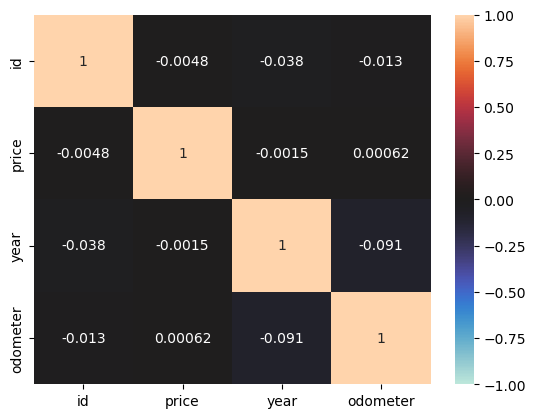

In [29]:
features_correlation = df2.corr()
sns.heatmap(features_correlation, annot=True, vmin=-1, vmax=1, center=0)

Text(0, 0.5, 'Price')

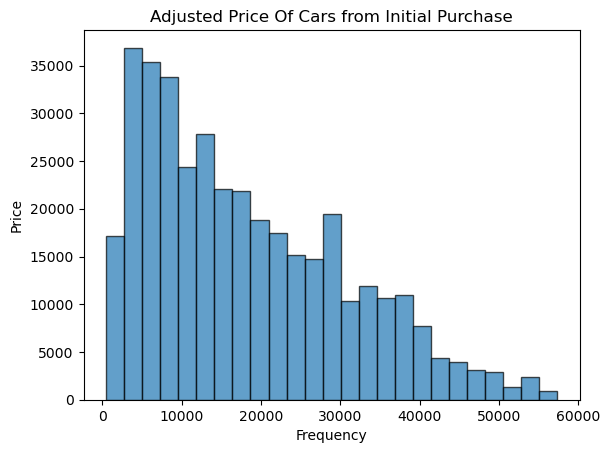

In [13]:
plt.hist(newprice.price, bins=25, alpha = 0.7, edgecolor='black')
plt.title('Adjusted Price Of Cars from Initial Purchase')
plt.xlabel('Frequency')
plt.ylabel('Price')

There is also a catagory for title status, let's explore that and compaire it to the price as well. 

In [14]:
df2["title_status"].value_counts()

clean         74881
rebuilt        2699
salvage        1125
lien            683
missing         169
parts only       46
Name: title_status, dtype: int64

[Text(0.5, 1.0, 'Price of Car compared to their Title Statuses')]

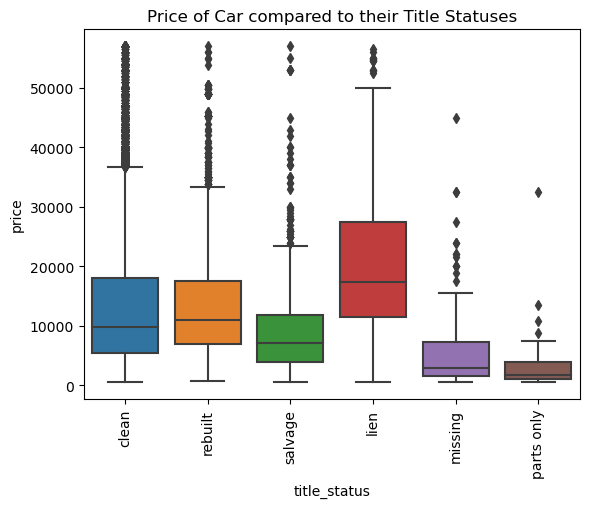

In [15]:
title = sns.boxplot(data=df2, x='title_status', y=newprice.price)
title.set_xticklabels(title.get_xticklabels(),rotation=90)
title.set(title= "Price of Car compared to their Title Statuses")

Ignoring the outliers, it looks as though the statuses that really contribute to price are clean and lien titles. Rather, they contribute *MORE* to the price, which makes sense if you think about it. (after looking up what Lien is) Clean and lien cars stay priced higher becuase they are still with all the original pieces that they were bought with, so there is no worry about having fake car parts or worse-- having a whole part of your car be missing.  



We can also take a look and compare the above to the Condition of the car as well, see below. 

[Text(0.5, 1.0, 'Price of Car compared to their Stated Conditions')]

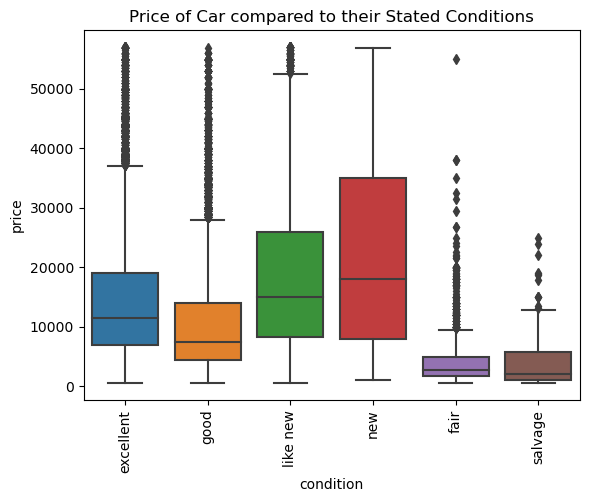

In [16]:
title = sns.boxplot(data=df2, x='condition', y=newprice.price)
title.set_xticklabels(title.get_xticklabels(),rotation=90)
title.set(title= "Price of Car compared to their Stated Conditions")

Looking at this, the data is reading as it would be expected. On a scale, things that are newer would be pricier, and the pricing go down as the condition "deteriroates" so to speak (for example, salvage cars not being as pricey). Let's make a new dataframe that is dealing with the catagories we will use for the modeling:

<AxesSubplot:>

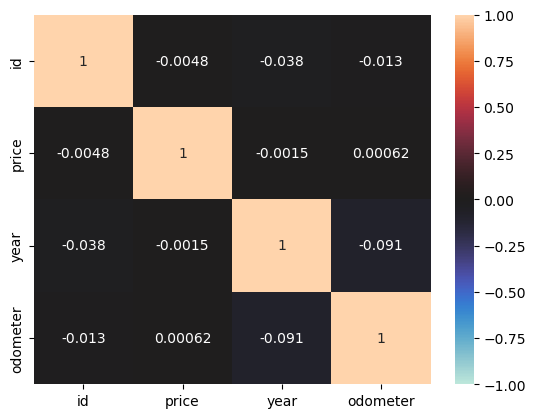

In [17]:
features_correlation = df2.corr()
sns.heatmap(features_correlation, annot=True, vmin=-1, vmax=1, center=0)

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

df = newprice[["price", "manufacturer", "model", "condition", "fuel", "odometer", "title_status"]]

#dropping NaN values from the dataframe df
df=df2.dropna()
df.shape

df.describe()

---
y = df['price']
X = df.drop(columns=['price'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

X_train.corr()




---

pipeLR = Pipeline([('scale', StandardScaler()),
                     ('linreg', LinearRegression())])
    
pipeLR.fit(X_train, y_train)
train_preds_LR = pipeLR.predict(X_train)
y_preds_LR = pipeLR.predict(X_test)
train_mses_LR = mean_squared_error(y_train, train_preds_LR)
test_mses_LR = mean_squared_error(y_test, y_preds_LR)
train_r2score_LR = r2_score(y_train, train_preds_LR)
test_r2score_LR = r2_score(y_test, y_preds_LR)

Ok, so we begin by doing some encoding.....


In [18]:
print(df2.columns)


contin_var = df2.select_dtypes(include=['int64','float64'])
cate_var = df2.select_dtypes(include='object')
cols=cate_var.columns


Index(['id', 'region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN',
       'drive', 'size', 'type', 'paint_color', 'state'],
      dtype='object')


In [19]:
lb = LabelEncoder()

for col in cate_var[cols]:
    cate_var[col] = lb.fit_transform(cate_var[col])

In [20]:
contin_var.reset_index(drop = True, inplace=True)
cate_var.reset_index(drop = True, inplace=True)

df_concat = pd.concat([contin_var,cate_var], axis = 1)
df_concat.head()

,id,price,year,odometer,region,manufacturer,model,condition,cylinders,fuel,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7316356412,15000,2013.0,128000.0,16,13,3879,0,5,2,0,0,19827,2,1,10,0,1
1,7314560853,19900,2004.0,88000.0,16,13,4244,2,6,0,0,0,19827,0,1,8,1,1
2,7313406529,14000,2012.0,95000.0,16,16,6360,0,5,2,0,0,19827,1,1,5,9,1
3,7312847466,22500,2001.0,144700.0,16,13,4376,2,6,0,0,1,19827,2,1,10,10,1
4,7312144944,15000,2017.0,90000.0,16,10,2248,0,6,2,4,0,19827,2,2,9,5,1


In [21]:
X=df_concat.drop(columns='price')
y=df_concat['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
#train vars

std = StandardScaler()
robust = RobustScaler()

train_std = X_train[['odometer']]
cont_std = std.fit_transform(train_std)

cont_xtrain=pd.DataFrame(cont_std,columns=['odometer'])
print(cont_xtrain.head())


###########################



tempdf=X_train.drop(columns='odometer')

cont_xtrain.reset_index(drop = True, inplace=True)
tempdf.reset_index(drop = True, inplace=True)

X_train_scaled_concat = pd.concat([cont_xtrain,tempdf], axis = 1)
X_train_scaled_concat.head()

   odometer
0 -0.075395
1  0.065472
2  0.447227
3  0.050845
4 -0.027892


,odometer,id,year,region,manufacturer,model,condition,cylinders,fuel,title_status,transmission,VIN,drive,size,type,paint_color,state
0,-0.075395,7316216809,2002.0,197,13,2771,0,6,2,0,0,19827,2,1,9,8,17
1,0.065472,7316544953,2008.0,20,20,2511,0,5,2,0,0,19827,0,1,0,10,20
2,0.447227,7316802822,2007.0,293,38,6673,2,3,3,0,0,19827,1,1,4,9,4
3,0.050845,7307259123,2013.0,288,17,3349,0,3,2,0,0,19245,1,0,9,1,45
4,-0.027892,7308025725,2004.0,386,4,9272,2,5,2,0,0,19827,0,1,0,5,20


In [23]:
X_train.corr()

,id,year,odometer,region,manufacturer,model,condition,cylinders,fuel,title_status,transmission,VIN,drive,size,type,paint_color,state
id,1.000000,-0.039932,-0.015467,-0.017841,0.030812,-0.010047,0.007189,-0.023486,0.033903,0.015935,0.012104,0.062257,0.026367,-0.010832,-0.013770,-0.004652,-0.100982
year,-0.039932,1.000000,-0.094263,0.004912,0.048423,0.054712,-0.043823,-0.193832,-0.016020,0.052515,-0.181250,-0.190547,-0.255768,0.019659,0.023356,0.034309,0.008361
odometer,-0.015467,-0.094263,1.000000,-0.010629,-0.001892,0.000777,0.023665,0.044569,-0.035909,-0.023151,0.003819,0.043660,-0.009286,-0.004996,0.005740,0.003261,-0.016770
region,-0.017841,0.004912,-0.010629,1.000000,0.003705,0.003551,-0.020794,0.009640,0.004494,-0.022330,-0.005295,-0.032183,0.009746,-0.014830,-0.008031,-0.002227,-0.019191
manufacturer,0.030812,0.048423,-0.001892,0.003705,1.000000,-0.025645,-0.019964,-0.246296,0.032616,0.022721,0.047140,0.172880,-0.080499,0.020070,-0.016862,-0.023115,-0.021551
model,-0.010047,0.054712,0.000777,0.003551,-0.025645,1.000000,-0.009245,0.092565,0.024568,-0.018061,-0.030203,-0.005911,-0.127574,0.016086,-0.118358,0.017611,0.022489
condition,0.007189,-0.043823,0.023665,-0.020794,-0.019964,-0.009245,1.000000,0.024105,-0.011986,0.036937,-0.004006,0.057796,0.051587,-0.014628,0.030698,0.010054,0.023194
cylinders,-0.023486,-0.193832,0.044569,0.009640,-0.246296,0.092565,0.024105,1.000000,-0.199456,-0.058256,-0.091101,-0.130662,-0.022633,-0.025775,0.042467,0.033919,0.025525
fuel,0.033903,-0.016020,-0.035909,0.004494,0.032616,0.024568,-0.011986,-0.199456,1.000000,0.018587,0.002864,0.138359,0.104788,0.068334,-0.185925,-0.068618,-0.019775
title_status,0.015935,0.052515,-0.023151,-0.022330,0.022721,-0.018061,0.036937,-0.058256,0.018587,1.000000,-0.004128,0.070666,-0.005797,-0.000308,0.001085,-0.024762,0.004695


In [24]:
#test vars

In [25]:
test_std = X_test[['odometer']]
cont_std_test = std.transform(test_std)

cont_xtest=pd.DataFrame(cont_std_test,columns=['odometer'])
print(cont_xtest.head())

tempdf2=X_test.drop(columns='odometer')

cont_xtest.reset_index(drop = True, inplace=True)
tempdf2.reset_index(drop = True, inplace=True)

X_test_scaled_concat = pd.concat([cont_xtest,tempdf2], axis = 1)
X_test_scaled_concat.head()

   odometer
0 -0.137397
1  0.127715
2 -0.104251
3  0.283720
4 -0.116276


,odometer,id,year,region,manufacturer,model,condition,cylinders,fuel,title_status,transmission,VIN,drive,size,type,paint_color,state
0,-0.137397,7315466227,2013.0,234,4,9308,3,6,2,0,0,19827,0,1,0,0,34
1,0.127715,7312540502,2007.0,267,26,1564,0,5,2,4,0,19827,0,1,10,1,38
2,-0.104251,7316116554,2013.0,307,36,5619,0,5,2,0,0,13832,0,1,9,1,9
3,0.283720,7315063106,2003.0,235,13,2771,3,6,2,0,0,9884,2,1,9,8,45
4,-0.116276,7310341897,2005.0,133,26,1564,2,6,2,0,0,19827,2,0,2,9,25


In [26]:
#Simple Linear Regression

lr = LinearRegression()


lr.fit(X_train_scaled_concat, y_train)
pred = lr.predict(X_test_scaled_concat)


print('MSE:', mean_squared_error(y_test,pred))
print('R^2 score:', r2_score(y_test,pred))

MSE: 636437844343173.4
R2 score: -4.439626821484133e-05


In [27]:
#Ridge Regression

ridge = Ridge()


ridge.fit(X_train_scaled_concat, y_train)
pred = ridge.predict(X_test_scaled_concat)


print('MSE:', mean_squared_error(y_test,pred))
print('R^2 score:', r2_score(y_test,pred))

MSE: 636437844435292.9
R2 score: -4.439641296349883e-05


In [28]:
#Lasso Model

lasso = Lasso()


lasso.fit(X_train_scaled_concat, y_train)
pred = lasso.predict(X_test_scaled_concat)


print('MSE:', mean_squared_error(y_test,pred))
print('R^2 score:', r2_score(y_test,pred))

MSE: 636437845506449.8
R2 score: -4.439809608847156e-05


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

Looking at what I yeilded from our regression tools, here are again listed the MSE's:


Linear: 636437844343173.4

Ridge:  636437844435292.9

Lasso:  636437845506449.8



Now that I brought them all together, we can see that the mean square error's are sooooo nearly close together, but it appears as though the Linear Regression Model is the best one as it is the smallest. If the mean square error is larger, then that means the error is also larger, therefore we go with the Linear Regression Model. 

Next, let's look at the r^2:


Linear: -4.439626821484133e-05

Ridge:  -4.439641296349883e-05

Lasso:  -4.439641296349883e-05


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

Let's go over the CRISP-DM Framework again. 

Business Understanding: Our objective is to find what makes a used car most valuable. That is to say, what factors can used car dealers use in order to better price and thereafter sell their cars

Data Understanding/Preparation/Modeling: We looked at a very large dataset from Kaggle that contained information from over 426,000 cars. We then fine tuned that data and adjusted it slightly so that we may be able to work and manipulate it with code! For example, we removed missing values, or we filled in missing values with a mean value so that we could actually use that data column. After much manipulation, we see that the Regression model best used is the Linear Regression model. 

Evaluation/Deployment: As far as used cars go, if we look at the correlations, dealers should take a better look at which models of cars they are bringing in, as it seems to be the best way to yield the most money. Because of that the manufacteror kind of goes hand in hand with that, as only certain manu-s will make these certain models. Another thing I have noticed is that year is also kind of important. Models that of of recent years will be much more valuable than models that are much older.
